<a href="https://colab.research.google.com/github/vicdlp/CS_project/blob/main/CS_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Libraries:

In [2]:
!pip install biopython # Install the biopython library which contains the SeqIO module.
from Bio import SeqIO # to read protein sequences
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy import stats
import re

# Set plot style for a cleaner visual appearance
plt.style.use('seaborn-v0_8')

# Set the fontsize for various plot elements
plt.rcParams.update({
    'font.size': 20,            # General font size
    'axes.titlesize': 22,       # Title font size
    'axes.labelsize': 20,       # Axis label font size
    'xtick.labelsize': 18,      # X-tick label font size
    'ytick.labelsize': 18,      # Y-tick label font size
    'legend.fontsize': 16,      # Legend font size
    'figure.figsize': (12, 8),  # Set default figure size to 16x9
    'legend.frameon': True,
    'legend.edgecolor' : '0.1'
})


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 13.2 MB/s eta 0:00:00


# Task 1 : Pre-processing of data and One-Hot encoding

  After reading the data from the ".fasta" files, the goal is to convert the protein sequences of our data set into variables that will be easier to manipulate numerically. The sequences are made of the 20 amino-acids (AA), and the alignment gap "-". They are of the form, for example : "--ATHG--MPPQR...", and are each of length 96.


  The first idea would be to associate a value to each AA and to store the sequence in a 96 dimensional vector. However this would create a distance relationship between amino-acids, because the AA labeled with 20 would be much closer (for the computer that didn't study biology) to the one labeled 19, than to the one labeled with 1, which is not true in reality, because there is no order relationship between AA (they are just the elementary bricks of a sequence, and labeling them with another number shouldn't change their relationships).

  Therefore, we must use one-hot encoding, which consist to uniquely associate each AA, not with a number, but with one of the 21 vectors of the canonical basis of $\mathbb{R}^{21}$. This keeps all the AAs equidistant (for Euclidean distance, for example, $\sqrt{2}$). But our sequences are 96 AA long, so if we want to store each sequence as a datapoint, we must store it in a $21\times 96 = 2016$-dim vector.

  This is the content of the following sequences

In [3]:
nat = list(SeqIO.parse("MSA_nat_with_annotation.faa", "fasta")) # Natural data sampled from experiments

art = list(SeqIO.parse("MSA_art.faa", "fasta")) # Artificial data sampled from the generative model

In [8]:
def one_hot(sequence): # Converts a single sequence of length 96 to a 96 x 21 = 2016 dimensional vector

  matrix = np.zeros((21,96)) # matrix to store the encoded data

  # Dictionary that converts amino-acids to a number between 0 and 20
  amino_acids = {'A': 0, 'C': 1, 'D': 2, 'E': 3, 'F': 4, 'G': 5, 'H': 6, 'I': 7, 'K':8, 'L':9, 'M':10, 'N':11, 'P':12, 'Q':13, 'R':14, 'S':15, 'T':16, 'V':17, 'W':18, 'Y':19, '-':20}

  for i in range(96): # for the i-th amino-acid of the sequence ...
    matrix[amino_acids[sequence[i]], i] = 1 # ... associate the corresponding 21 dim vector in column i

  return matrix.flatten() # return the flatten matrix to get the data-point as a vector



def encode(data): # Converts the dataset to a matrix containing the one-hot encoded sequences

  matrix = np.zeros((len(data),2016))

  for i in range(len(data)):
    matrix[i] = one_hot(data[i].seq)

  return matrix


def label(data): # Extracts the labels of the dataset : Functional sequence (y=1) or Non Functional sequence (y=0)
  label = np.zeros(len(data))
  for i in range(len(data)):
    if re.search(r"functional_true", data[i].description):
      label[i] = 1
    else:
      label[i] = 0

  return label

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Rescaling the data : x' = (x-mu)/sigma     (seems not necessary here ?)

# Natural sequences dataset
X_nat = encode(nat)
y_nat = label(nat)

scaler.fit(X_nat)
X_nat = scaler.transform(X_nat)

# Artificial sequences dataset
X_art = encode(art)
y_art = label(art)

scaler.fit(X_art)
X_art = scaler.transform(X_art)

Rescaling is useful to give the same importance to all features, as their range can vary drastically, but here, it seems that all the 2016 features were already centered and had approximatively the same variance. This is probably a consequence of our encoding.

# Task 2 : Principal Component Analysis

So far, we have embedded our data in a 2016-dim. space. But none of these dimension has a clear physical interpretation and we cannot interpret them just by looking at a data point. However, we can try to implement dimensional reduction, in order to get a grasp of the signal hidden in the noise. Indeed, if we can go from 2016 to 2 dimension, we will be able to plot our data points, and see if we can observe any charachteristics of the dataset. For this, we have at our disposal Principal Component Analysis (PCA). It consists of computing the Sample Covariance Matrix : $$C_{ij} = \frac{1}{M} \sum_{k=1}^M X_{i}^kX_j^k$$ where $X_i^k$ is the composant $i$ of the $k$-th data point. It is a $2016\times 2016$ matrix that gives an estimation over the dataset of how the variable $X_i$ is correlated to the variable $X_j$. Then, when looking at the eigenvalues of this matrix (also called the principal components of the dataset, hence the name of this method), we will typically that there is a few large eigencalues and that most of the others are very small. Thus by keeping only the first 2 biggest eigenvalues we can extract a significant part of the signal contained in the data while only having a few variables instead of 2016. These principal components also don't have a clear physical interpretation, but they significantly help to understand the underlying structure of the data.

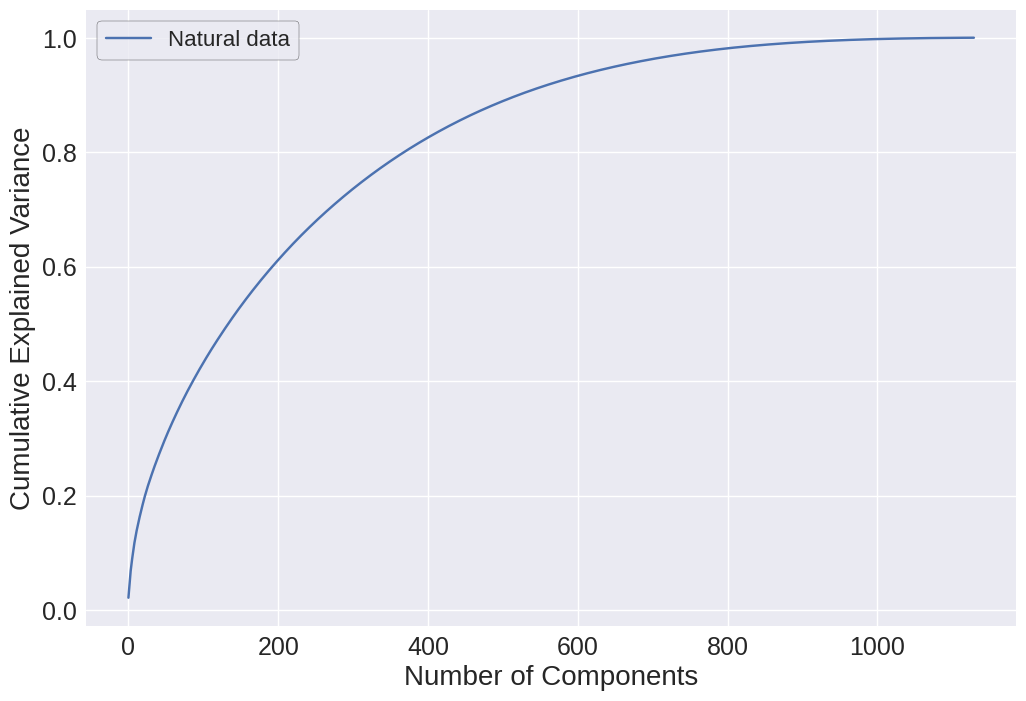

The explained variance ratio for the first two dimension of the natural data is  3.78 %
The number of components needed to keep 90% of the signal is 522


In [24]:
# Fit PCA without specifying the number of components to compute variance ratios for all components
pca_nat = PCA().fit(X_nat)
evr_nat = np.cumsum(pca_nat.explained_variance_ratio_)
compression = PCA(0.9)
X_nat_pca_nat = compression.fit_transform(X_nat)

# Plot the cumulative explained variance as a function of the number of components
plt.figure()
plt.plot(evr_nat, label = "Natural data") # Cumulative sum of explained variance
plt.legend()
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

print("The explained variance ratio for the first two dimension of the natural data is ", round(evr_nat[1]*100,2), '%')
print("The number of components needed to keep 90% of the signal is", compression.n_components_)

As expected, signal is not uniformly distributed along all directions of the embedding space. However if we only keep the first 2 dimension we, will keep only 3.78% of the signal in the data, and that in order to keep 90% of the signal we would need 522 components. Moreover, we can note that we only have around 1000 singular values and not 2016, this is because we have more features than data points, thus all the other singular values are zero. This tells us that we should not try to interpret too much the 2D projection of the data points as it cannot really capture the complexity of this dataset. Nevertheless, it can still be useful to see how it looks like. Moreover, we will be able later when doing more complicated tasks (like DNN and Boltzmann machines) to feed our model with dimensionnally reduced data (thus losing a bit of signal), but this should help considerably the training time.

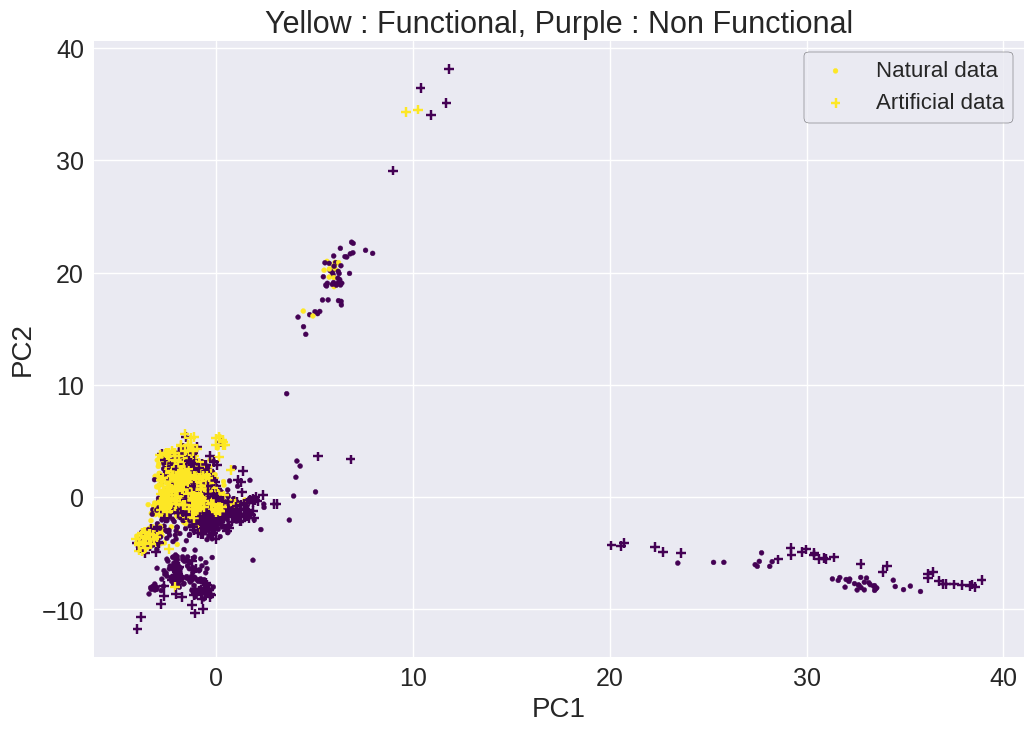

In [25]:
pca = PCA(n_components=2)

X_nat_pca = pca.fit_transform(X_nat) # Finding the 2 PCs of the Natural data and projecting the data onto them
X_art_pca = pca.transform(X_art) # Projecting the Artificial data on the 2 PCs of the Natural data

plt.figure()
plt.scatter(X_nat_pca[:, 0], X_nat_pca[:, 1], c=y_nat, cmap='viridis', label = "Natural data", marker = ".")

plt.scatter(X_art_pca[:, 0], X_art_pca[:, 1], c=y_art, cmap='viridis', label = "Artificial data", marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Yellow : Functional, Purple : Non Functional')
plt.show()

We can see that functional and non functional are not well separted in PCA space, except in the line on the right. Thus we cannot infer wether a sequence is functional or not given its two PCs. But we can zoom on the main cloud of points to see if we can see any separation.

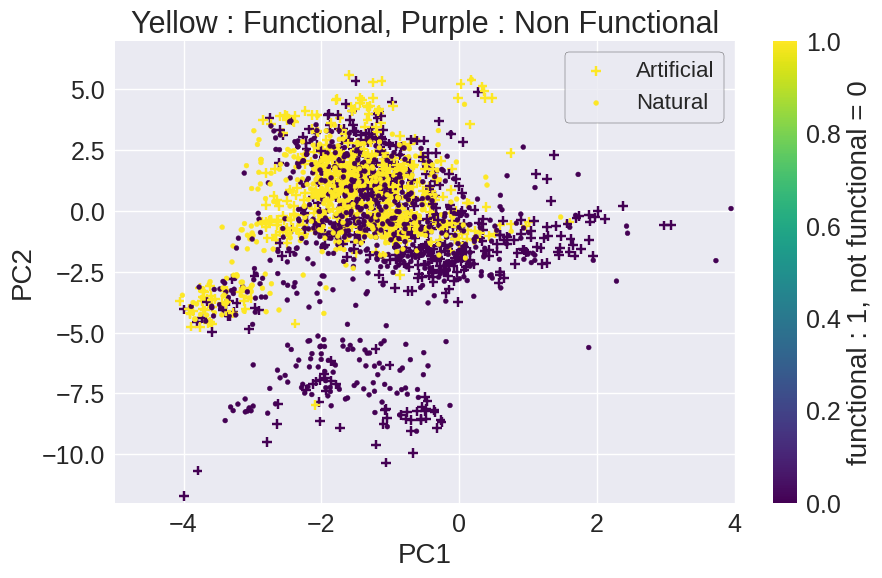

In [26]:
# Zoom on the cloud of points

plt.figure(figsize=(10, 6))

plt.xlim(-5,4)
plt.ylim(-12,7)

plt.scatter(X_art_pca[:, 0], X_art_pca[:, 1], c=y_art, cmap='viridis', label = "Artificial", marker = "+")
plt.scatter(X_nat_pca[:, 0], X_nat_pca[:, 1], c=y_nat, cmap='viridis', label = "Natural", marker = ".")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Yellow : Functional, Purple : Non Functional')
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.show()

Maybe in the lower part of the cloud, more points are non functional, but in the rest it is mixed.

A problem with PCA, is the fact that it is only able to perform linear transformations. But tipically data cannot be perfectly mapped to a smaller dimension without crossing itself. This means that initially far away points will get mapped to the same point. Another method to do dimensional reductional while taking into account this challenge is t-SNE. It is a non-linear transformation of the data, that aims at getting initially close points closer and getting initially far points even further. However, this non linear is not an explicit function and is only the result of an algorithm trying to minimize a Kullback-Leibler divergence for a given set of points. Thus if I add a point, I cannot get his mapping through the previous non-linear transform, and I have to start over. Again, it should not be interpreted too much but it is still useful tool, especially to understand the difference between the artificial and natural datapoints.

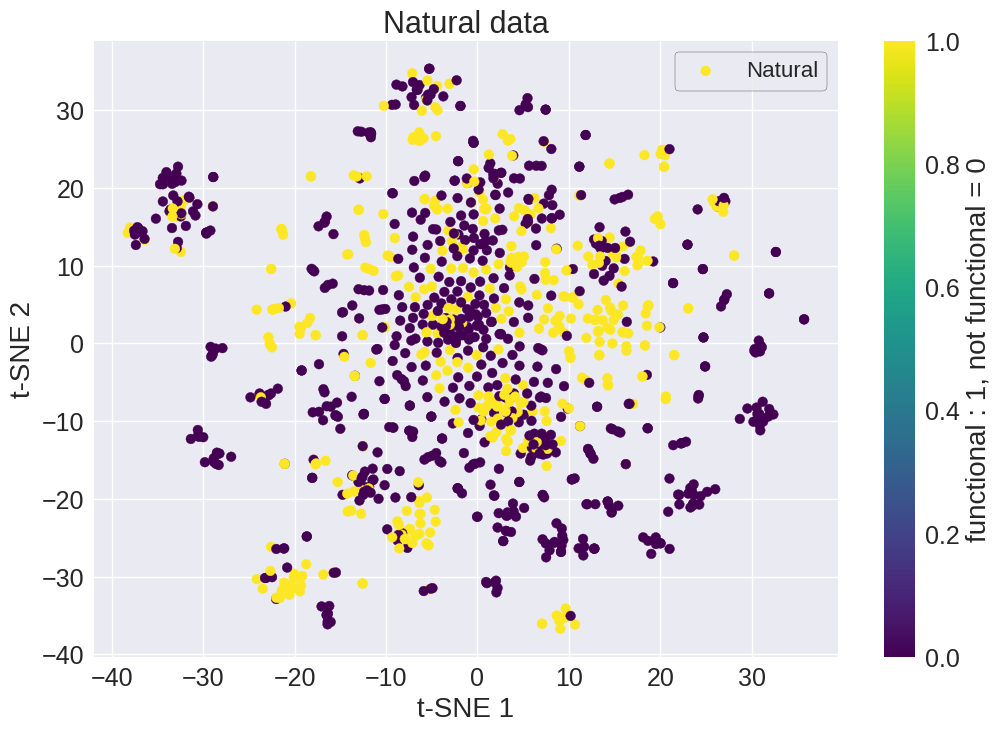

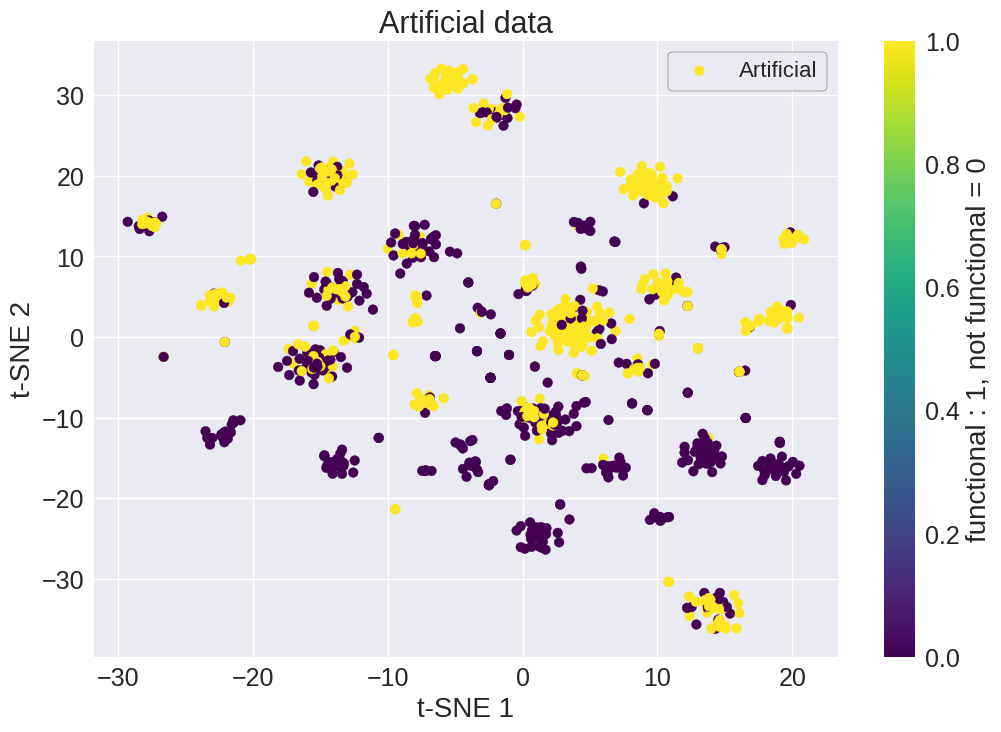

In [28]:
from sklearn.manifold import TSNE

# Initialize t-SNE to reduce the dimensionality to 2 components with a specified perplexity
tsne = TSNE(n_components=2, perplexity=50)

# Apply t-SNE to the data
X_art_embedded = tsne.fit_transform(X_art)
X_nat_embedded = tsne.fit_transform(X_nat)

# Create a scatter plot of the t-SNE transformed data
plt.scatter(X_nat_embedded[:, 0], X_nat_embedded[:, 1], c = y_nat, cmap='viridis', label = "Natural")
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Natural data')
plt.legend()
plt.show()

plt.scatter(X_art_embedded[:, 0], X_art_embedded[:, 1], c = y_art, cmap='viridis', label = "Artificial")
plt.colorbar(label=r'functional : 1, not functional = 0')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.title('Artificial data')
plt.legend()
plt.show()

Back to PCA, we want know to focus on (qualitative) difference between the artificial and natural datapoints. For a given label (F or NF), if we plot them on the same graph, we can see that almost everywhere, artificial and natural data overlap. This means that the generated sequence have quite well captured the statistical distribution of the natural sequences, which means that the generative model has done a good job. However, there is still a difference in the diagonal blob at the top. We can see that artificial and natural datapoints are clearly mapped splitted in two different areas, which tells us that maybe, the generative model is missing out some properties.

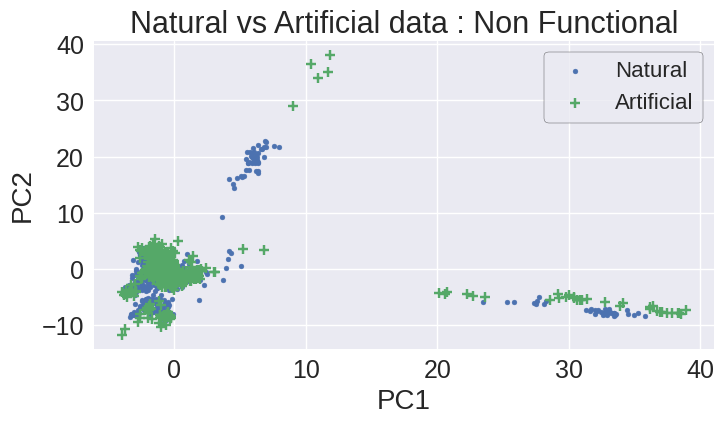

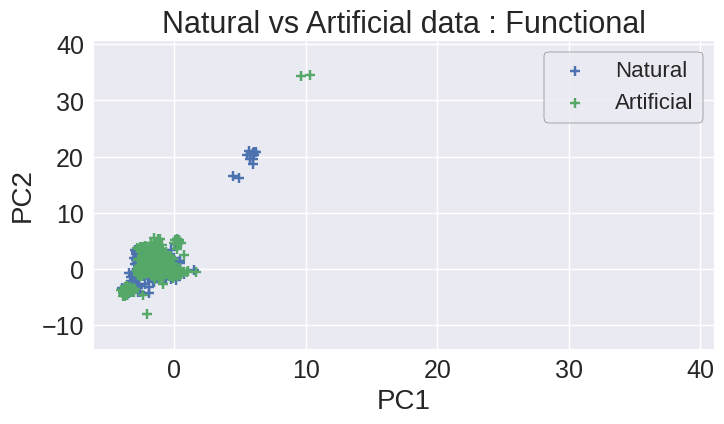

In [37]:
plt.figure(figsize = (8,4))

# Filter the data points where the label is 0
X_nat_pca_NF = X_nat_pca[y_nat == 0]
X_art_pca_NF = X_art_pca[y_art == 0]

# Plot only the filtered points
plt.scatter(X_nat_pca_NF[:, 0], X_nat_pca_NF[:, 1], label='Natural', marker = ".")
plt.scatter(X_art_pca_NF[:, 0], X_art_pca_NF[:, 1], label='Artificial', marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Natural vs Artificial data : Non Functional')

x_range = plt.gca().get_xlim()
y_range = plt.gca().get_ylim()

plt.show()


plt.figure(figsize = (8,4))

plt.xlim(x_range)
plt.ylim(y_range)

# Filter the data points where the label is 0
X_nat_pca_F = X_nat_pca[y_nat == 1]
X_art_pca_F = X_art_pca[y_art == 1]

# Plot only the filtered points
plt.scatter(X_nat_pca_F[:, 0], X_nat_pca_F[:, 1], label='Natural', marker = "+")
plt.scatter(X_art_pca_F[:, 0], X_art_pca_F[:, 1], label='Artificial', marker = "+")

plt.legend()
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Natural vs Artificial data : Functional')

x_range = plt.gca().get_xlim()
y_range = plt.gca().get_ylim()

plt.show()

# Task 3 Clustering


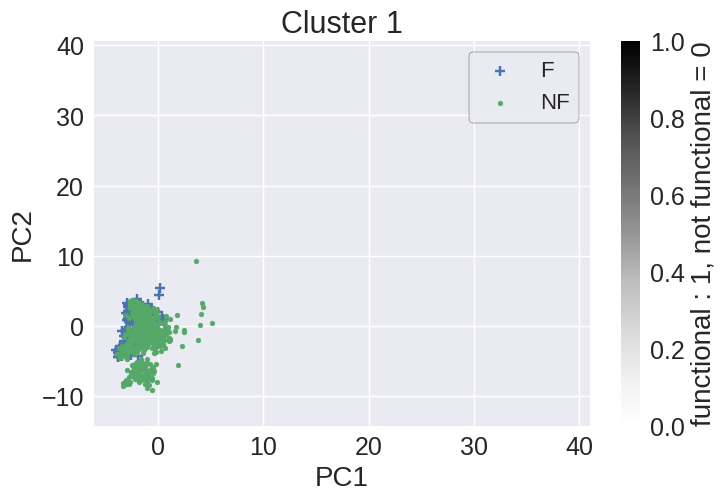

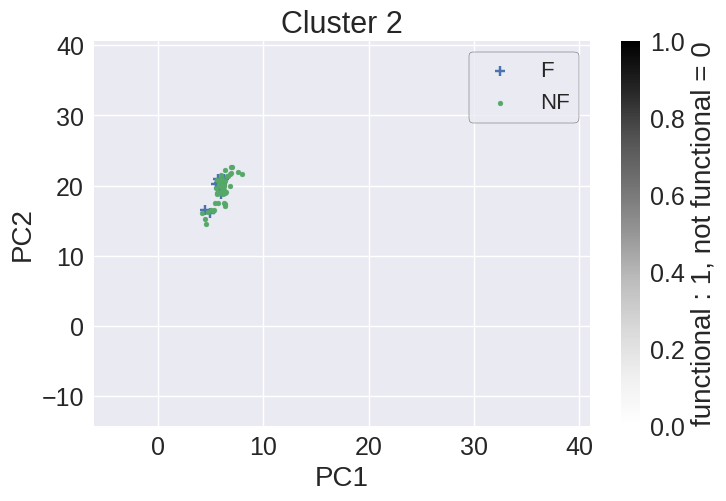

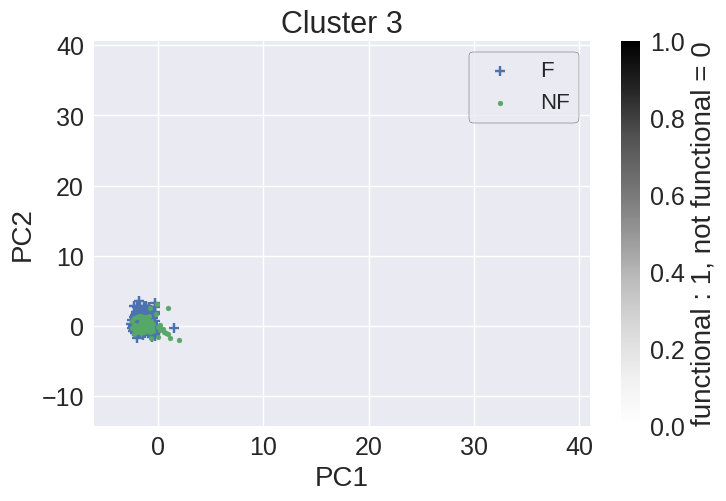

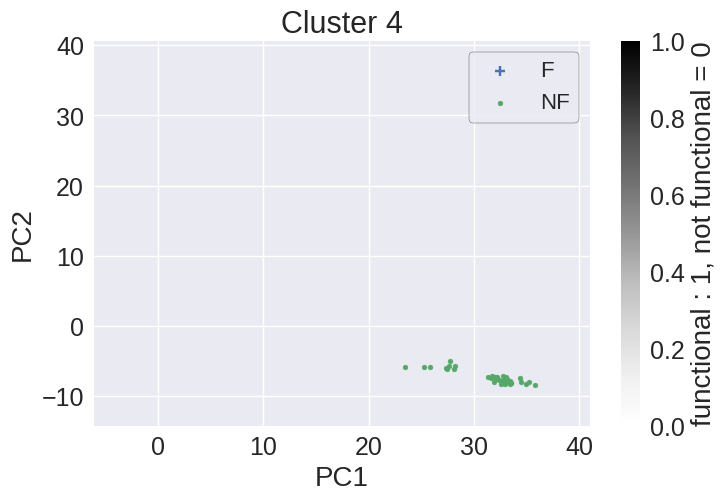

In [93]:
from sklearn.cluster import KMeans

k = 4 # Number of clusters

# Apply KMeans clustering to the natural data only
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X_nat)  # Fit KMeans

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

for i in range(k): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_nat_pca[mask]
  y_cluster = y_nat[mask]

  X_cluster_F = X_cluster[y_cluster == 1]
  X_cluster_NF = X_cluster[y_cluster == 0]

  # ...plot the cluster in PCA space with F or NF as colormap
  plt.figure(figsize=(8,5))
  plt.xlim(x_range)
  plt.ylim(y_range)
  plt.scatter(X_cluster_F[:, 0], X_cluster_F[:, 1], marker = '+', label = 'F')
  plt.scatter(X_cluster_NF[:, 0], X_cluster_NF[:, 1], marker = '.', label = 'NF')
  plt.legend()
  plt.colorbar(label=r'functional : 1, not functional = 0')
  plt.title(f'Cluster {i+1}')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()


k means for k=4 clusters does not manage to separate F and NF sequences, except the line on the right, where all the sequences are non functional (but we were able to see it by ourselves with our bare eyes, without any algorithm, so we do not learn much from this cluster). For the other clusters, F and NF sequences are clustered together, which means that F and NF cannot be differentiated just by looking at distances between points. We could try to use a different clustering algorithm that avoids this caveat, for instance DBScan, abd focus on the main blob.

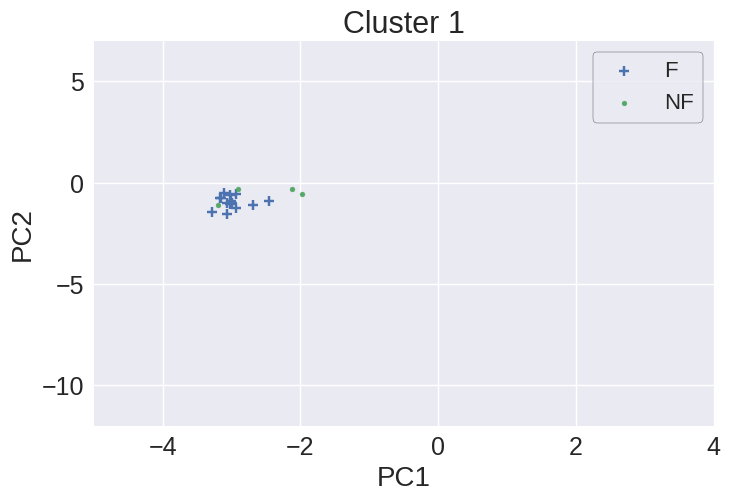

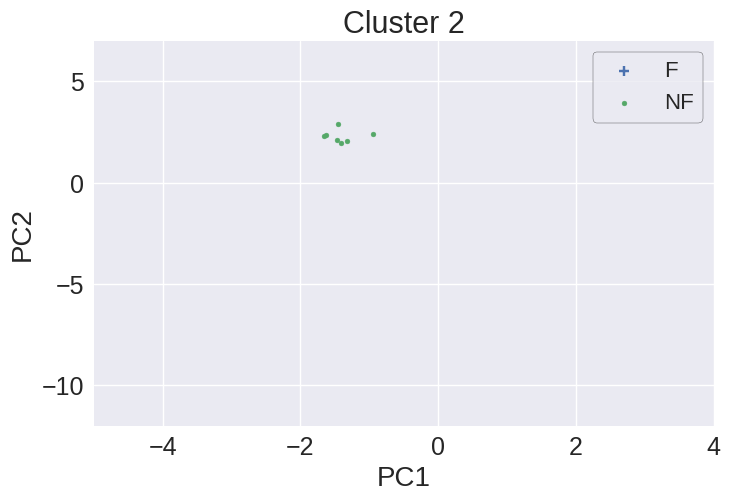

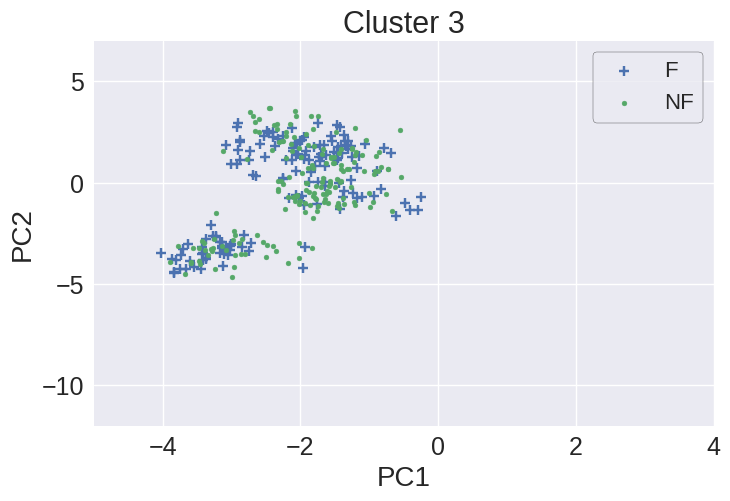

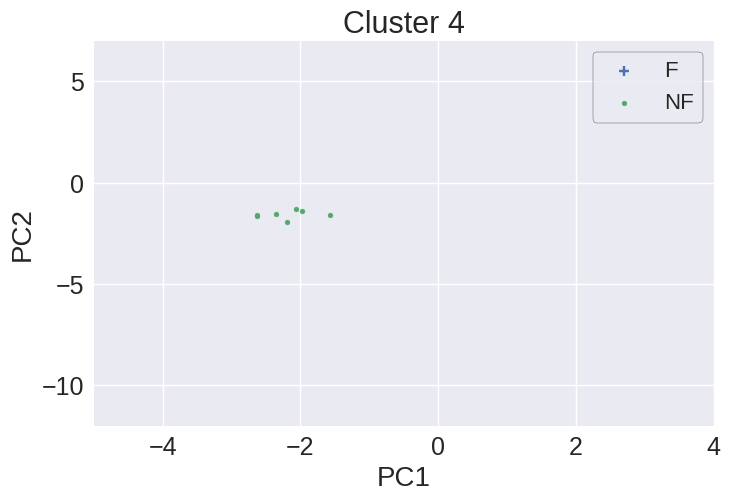

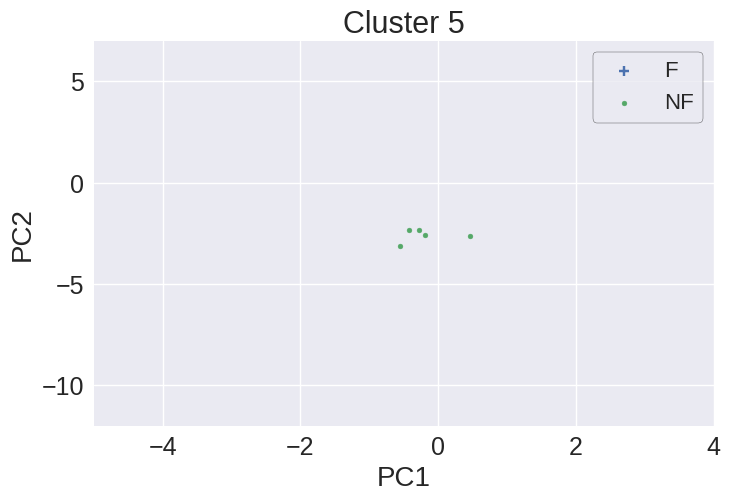

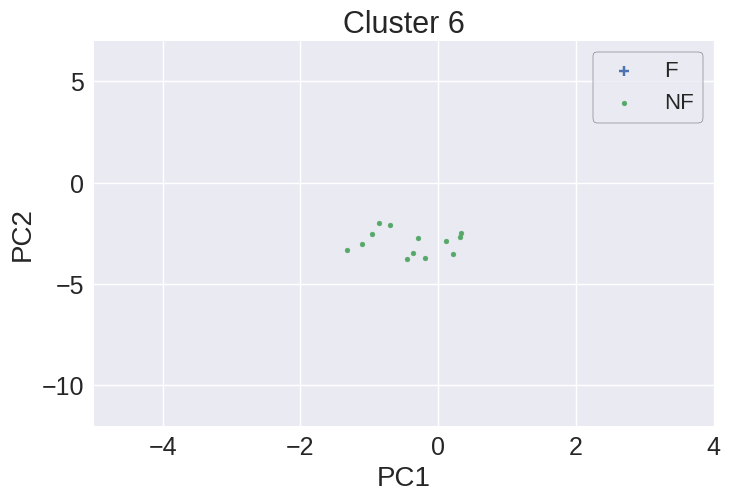

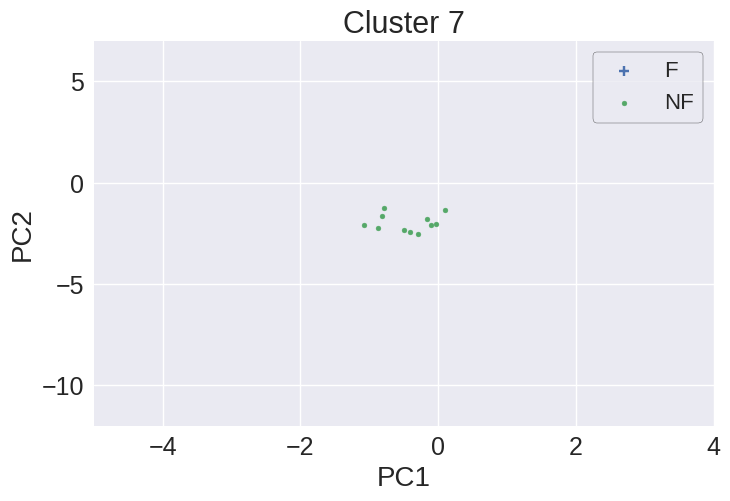

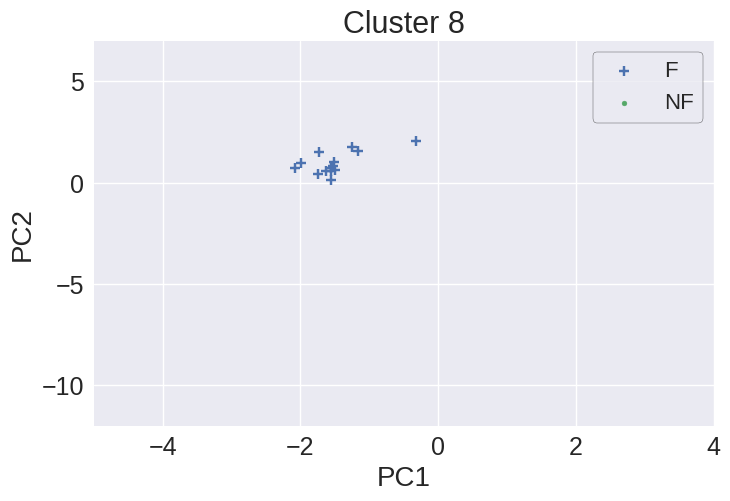

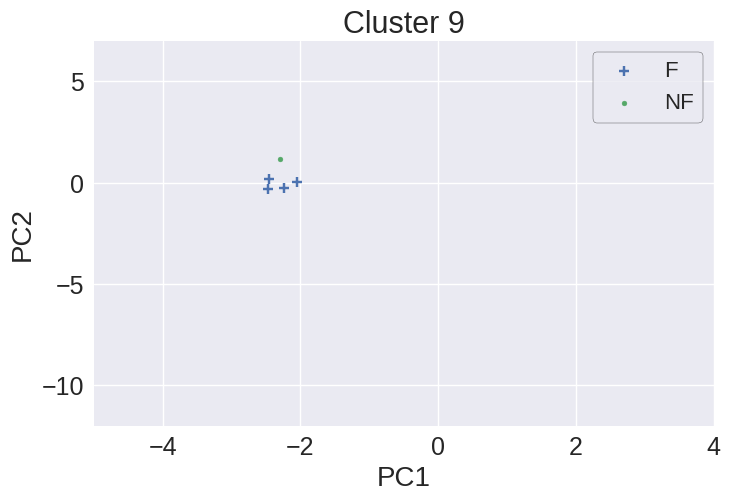

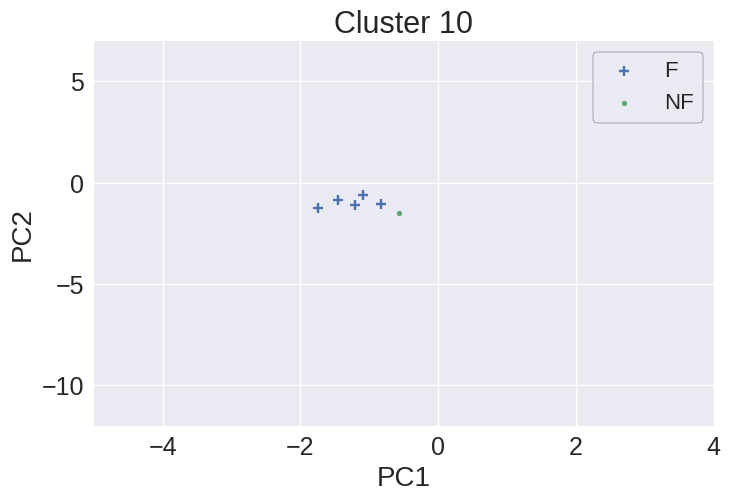

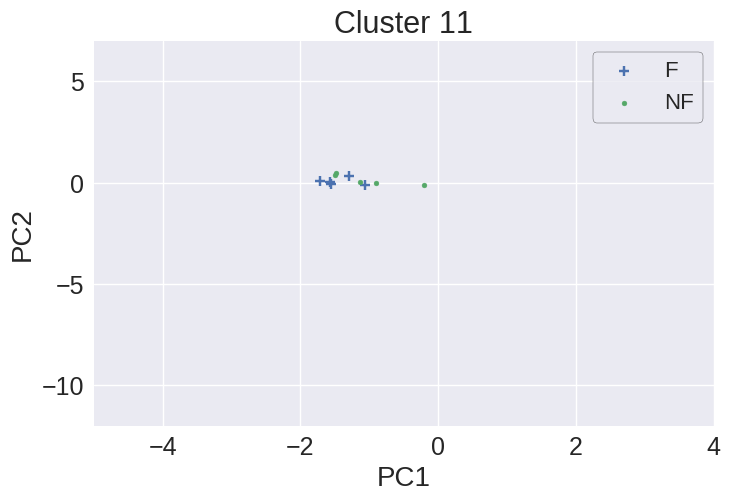

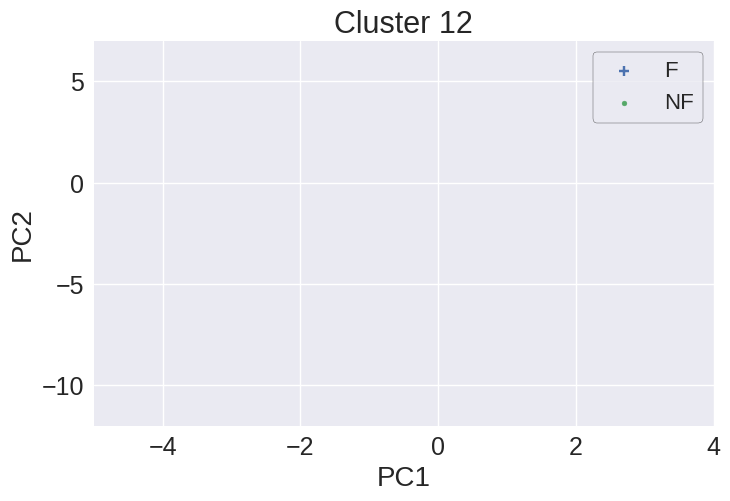

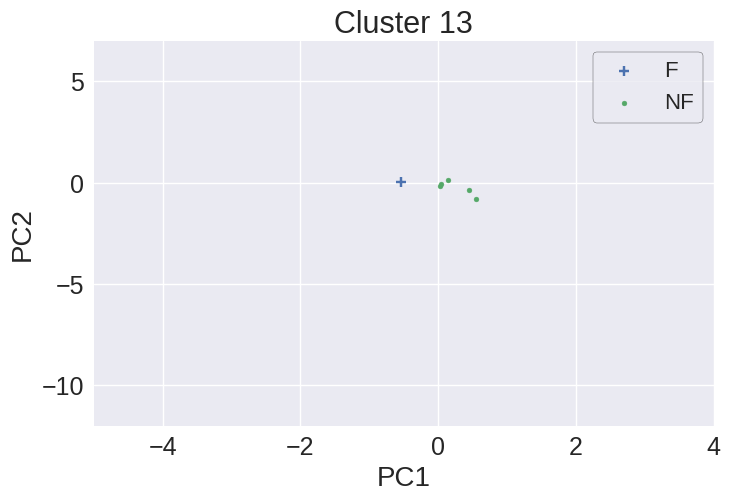

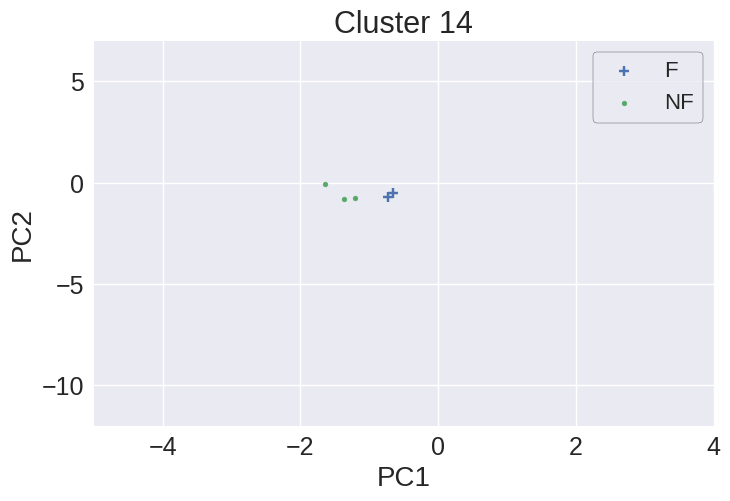

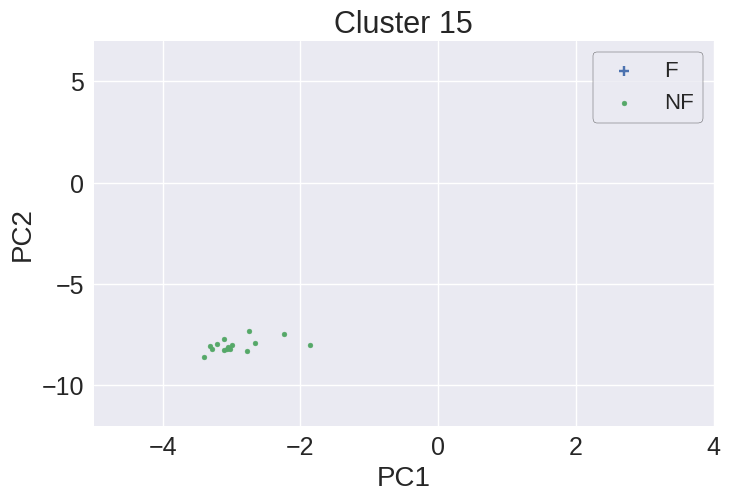

In [132]:
from sklearn.cluster import DBSCAN

eps = 40 # size of directly reachable area

# Apply dbscan clustering to the natural data only
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan.fit(X_nat)  # Fit of dbscan

# Get cluster labels for each data point
cluster_labels = dbscan.labels_

for i in range(max(dbscan.labels_)+1): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_nat_pca[mask]
  y_cluster = y_nat[mask]

  X_cluster_F = X_cluster[y_cluster == 1]
  X_cluster_NF = X_cluster[y_cluster == 0]

  # ...plot the cluster in PCA space with F or NF as markerstyle, centered on the main blob
  plt.figure(figsize=(8,5))
  plt.xlim(-5,4)
  plt.ylim(-12,7)
  plt.scatter(X_cluster_F[:, 0], X_cluster_F[:, 1], marker = '+', label = 'F')
  plt.scatter(X_cluster_NF[:, 0], X_cluster_NF[:, 1], marker = '.', label = 'NF')
  plt.legend()
  plt.title(f'Cluster {i+1}')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()

DBScan does a little bit better job at clustering the F and NF seperately. Many clusters have only NF sequences and there is even a cluster with only F sequences (cluster 8). But the rest of the clusters are still mixed, which indicates that the data has a very twisted high dimensional shape.

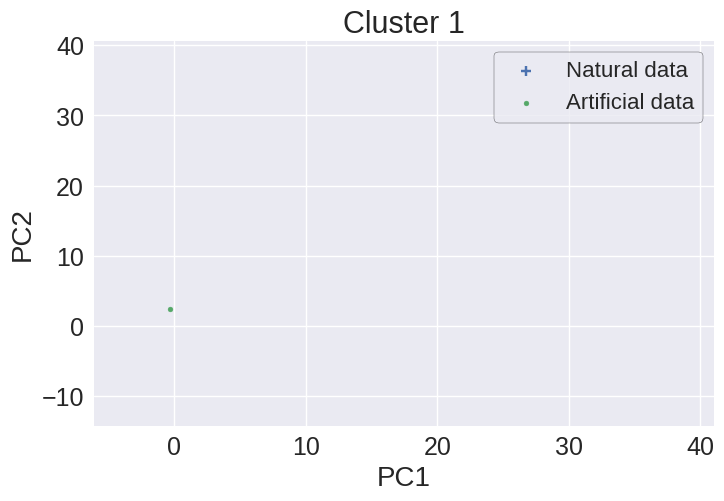

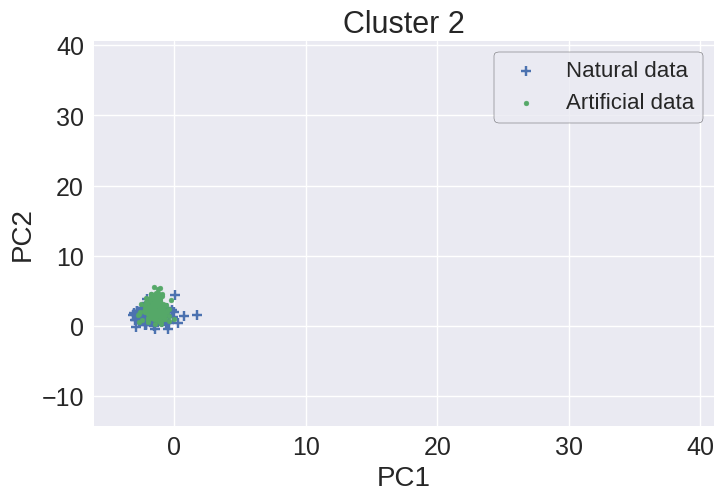

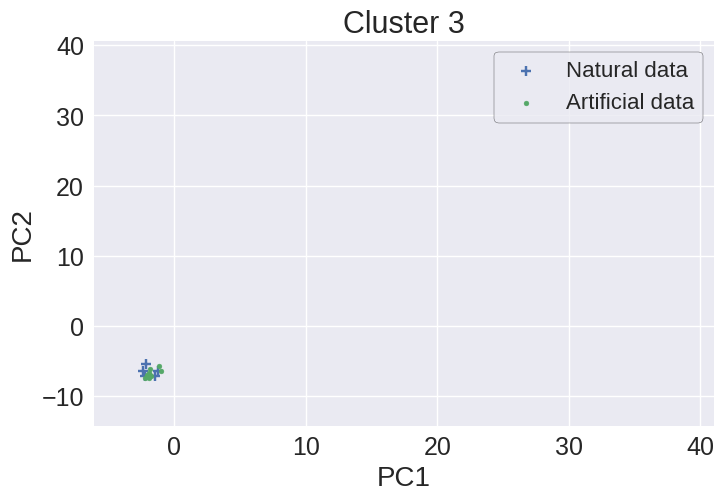

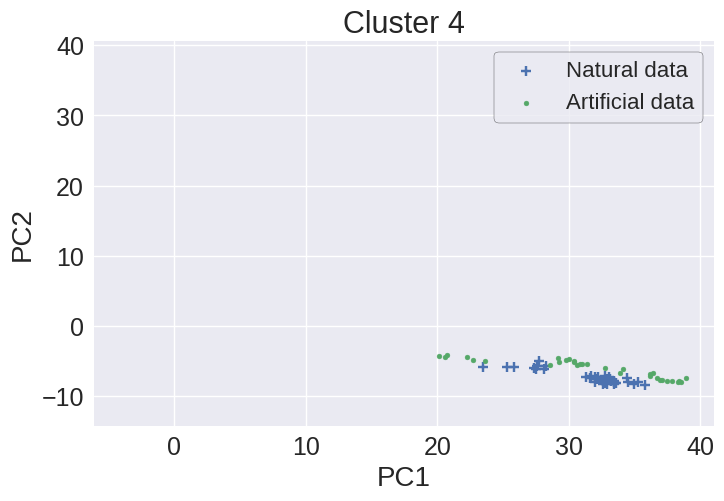

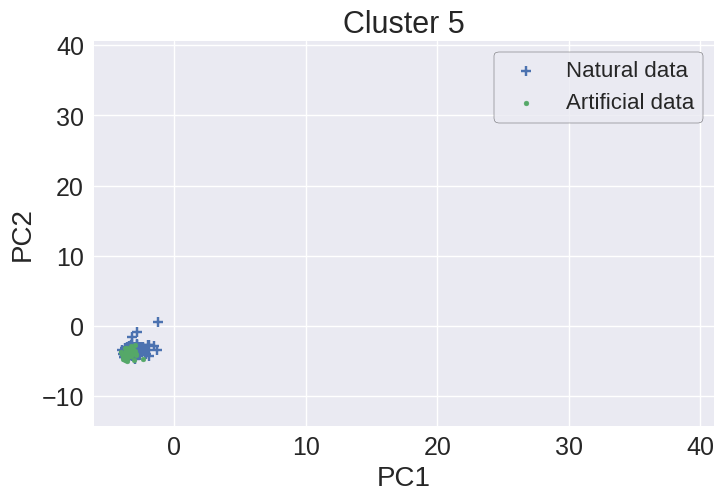

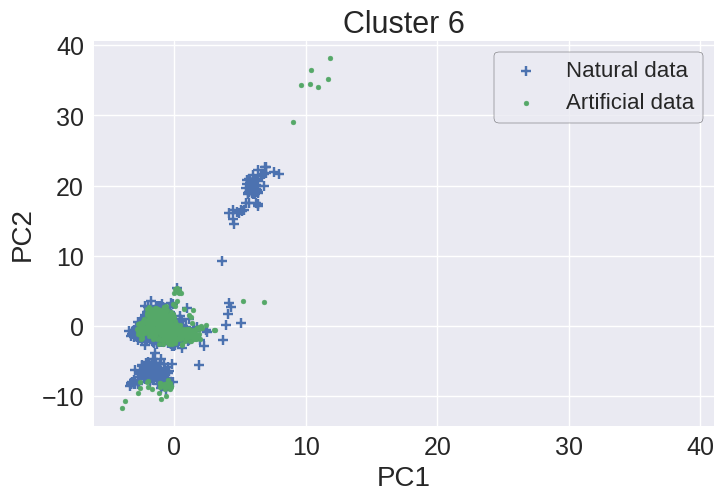

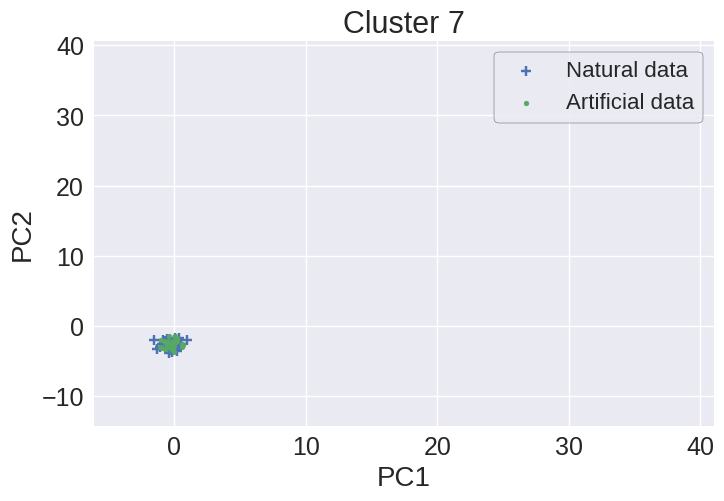

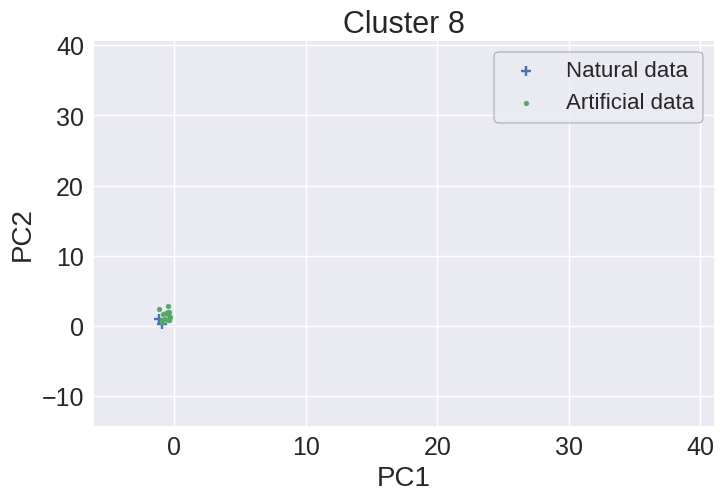

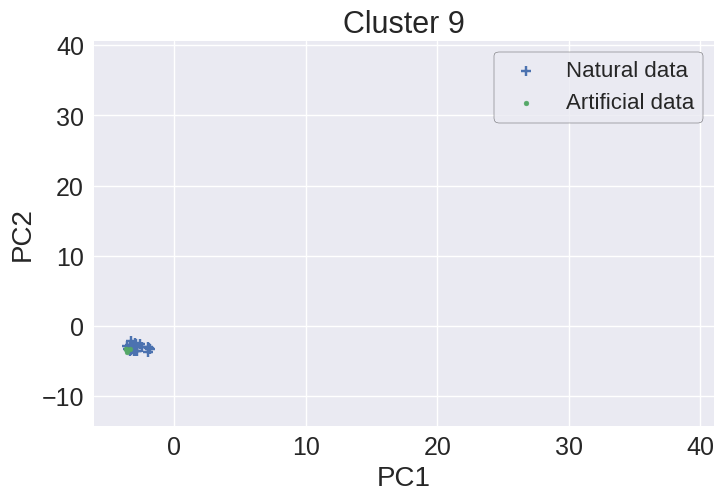

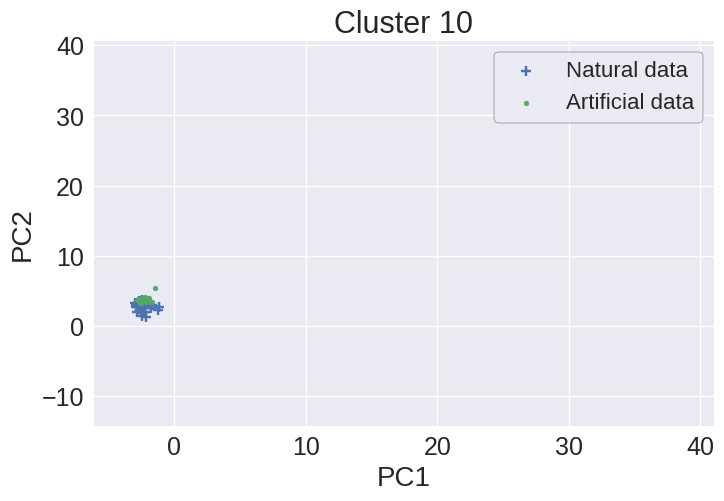

In [140]:
X = np.concatenate((X_nat, X_art))
X_pca = pca.transform(X)
y = np.concatenate((np.zeros(len(X_nat)), np.ones(len(X_art)))) # labels : 0 for natural data, 1 for artificial data

k = 10 # Number of clusters

# Apply KMeans clustering to the natural data only
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X)  # Fit KMeans

# Get cluster labels for each data point
cluster_labels = kmeans.labels_

for i in range(k): # for each cluster...
  mask = (cluster_labels == i)
  X_cluster = X_pca[mask]
  y_cluster = y[mask]

  X_cluster_nat = X_cluster[y_cluster == 0]
  X_cluster_art = X_cluster[y_cluster == 1]

  # ...plot the cluster in PCA space with F or NF as colormap
  plt.figure(figsize=(8,5))
  plt.xlim(x_range)
  plt.ylim(y_range)
  plt.scatter(X_cluster_nat[:, 0], X_cluster_nat[:, 1], marker = '+', label = 'Natural data')
  plt.scatter(X_cluster_art[:, 0], X_cluster_art[:, 1], marker = '.', label = 'Artificial data')
  plt.legend()
  plt.title(f'Cluster {i+1}')
  plt.xlabel('PC1')
  plt.ylabel('PC2')
  plt.show()

Even with 10 clusters, k-means is not able to tell apart natural and artificial sequences, which is a good sign for the quality of the generative model.